---
title: The Shape of a Magnetic Field
subtitle: From magnetic field vectors to Stokes parameters
authors: Nabil Brice
format:
    html: 
        code-fold: true
---


This notebook is written as a testset for the `sinar` package and its polarization capabilities with `sinar.entities.harmonics`.

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from matplotlib import cm

from sinar.entities.shapes import rotation

# Magnetic Field Vector

Without any magnetic monopoles, magnetic fields must satisfy $\nabla \cdot \vec{B} = 0$. For any potential $V$ that is able to describe a magnetic field, i.e. $\vec{B} = \nabla V$, the constraint on no-magnetic-monopoles translates to Laplace's equation: $\nabla^2 V = 0$ or $\Delta V = 0$, whose solutions in 3-dimensions are the spherical harmonics.

To compute the magnetic field vectors, the `dipole_vector` function is used from `sinar.entities.harmonics`.

In [2]:
from sinar.entities.harmonics import dipole_vector

def view_field(ax, elev_view=25, azim_view=30, orient=jnp.eye(3),
               field_components=jnp.array([1.0, 0.0]),
               title = ""):
    ax.view_init(elev=elev_view, azim=azim_view)
    
    # Grid points on the unit sphere
    elev = jnp.linspace(0, jnp.pi, 30)
    azim = jnp.linspace(0, 2*jnp.pi, 30)
    elev_grid, azim_grid = jnp.meshgrid(elev, azim)
    
    # Cartesian coordinates of the grid points
    x = jnp.sin(elev_grid) * jnp.cos(azim_grid)
    y = jnp.sin(elev_grid) * jnp.sin(azim_grid)
    z = jnp.cos(elev_grid)
    positions = jnp.stack([x, y, z], axis=-1)
    
    # Calculate magnetic vector field
    field = jax.vmap(lambda pos: dipole_vector(field_components, orient, pos))
    b = field(positions.reshape(-1, 3)).reshape((*elev_grid.shape, 3))
    
    # Extract components and calculate magnitude
    magnitude = jnp.linalg.norm(b, axis=-1)
    
    # Plot the sphere and prepare colors
    ax.plot_surface(x, y, z, color='lightblue', alpha=0.1)
    norm = plt.Normalize(magnitude.min(), magnitude.max())
    colors = cm.viridis(norm(magnitude)).reshape(-1, 4)
    
    # Plot the vector field (flattening in one step)
    ax.quiver(x.flatten(), y.flatten(), z.flatten(),
              b[:, :, 0].flatten(), b[:, :, 1].flatten(), b[:, :, 2].flatten(),
              length=0.25, normalize=True, color=colors)
    
    # Set labels and limits
    ax.set(xlabel='X', ylabel='Y', zlabel='Z', 
           xlim=[-1.2, 1.2], ylim=[-1.2, 1.2], zlim=[-1.2, 1.2],
           title=title)


In [3]:
dipole_component = jnp.array([1.0, 0.0, 0.0])
quadrupole_component = jnp.array([0.0, 1.0, 0.0])
octupole_component = jnp.array([0.0, 0.0, 1.0])

For ease of comparison of the magnetic field vector topology, the plots are shown in a single figure, side-by-side.

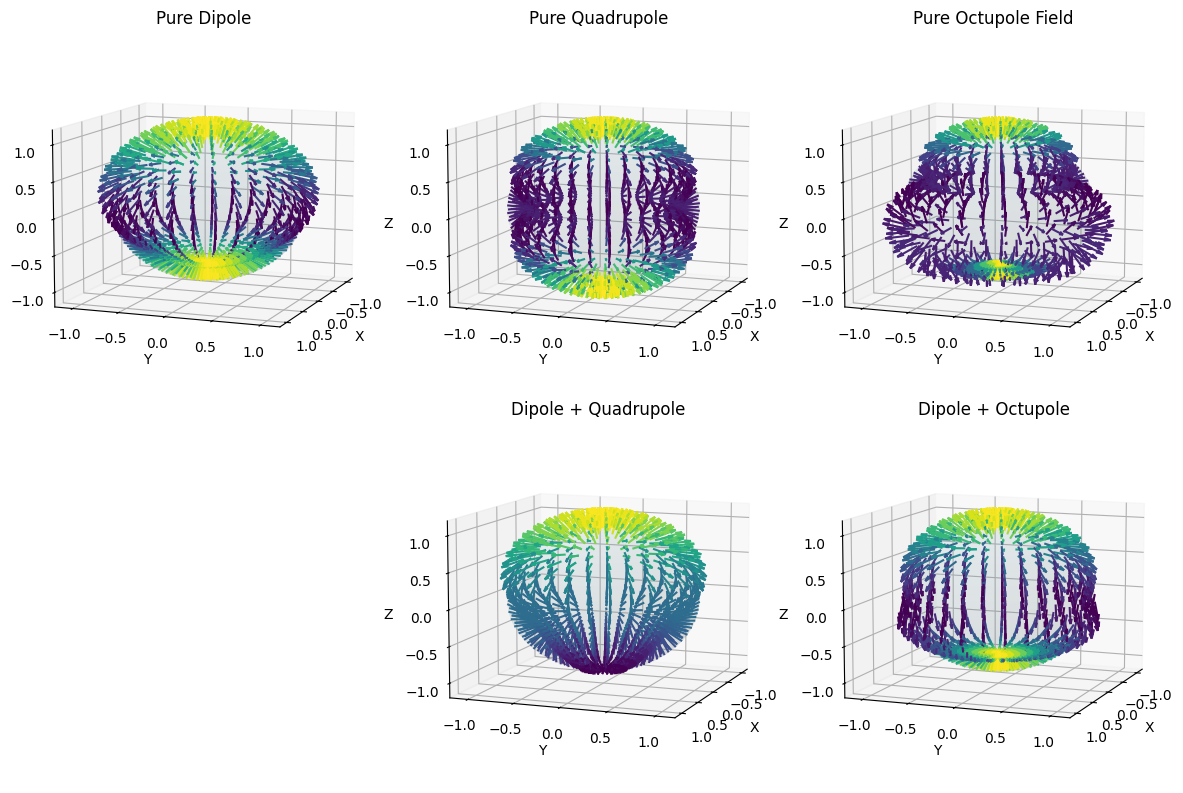

In [4]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(231, projection='3d')
elev_view, azim_view = 10, 21
view_field(ax1, elev_view=elev_view, azim_view=azim_view,
           field_components=dipole_component,
           title = "Pure Dipole")
ax2 = fig.add_subplot(232, projection='3d')
view_field(ax2, elev_view=elev_view, azim_view=azim_view,
           field_components=quadrupole_component,
           title = "Pure Quadrupole")
ax3 = fig.add_subplot(233, projection='3d')
view_field(ax3, elev_view=elev_view, azim_view=azim_view,
           field_components=octupole_component,
           title = "Pure Octupole Field")
ax5 = fig.add_subplot(235, projection='3d')
view_field(ax5, elev_view=elev_view, azim_view=azim_view,
           field_components=dipole_component+quadrupole_component,
           title = "Dipole + Quadrupole")
ax6 = fig.add_subplot(236, projection='3d')
view_field(ax6, elev_view=elev_view, azim_view=azim_view,
           field_components=dipole_component+octupole_component,
           title = "Dipole + Octupole")
plt.tight_layout()
plt.show()


From viewing the magnetic field vectors, it is clear that there are differences with the directions. When summed together, the magnetic field directions no longer look as neat as the pure dipole picture.

While at the nothern hemisphere, the magnetic field vectors can appear as similar to a dipole, maybe with a different component strength, the vector directions diverge more significantly in the southern hemisphere. This has implications for the phase-resolved and the overall geometric effect of the polarization.

# Polarization Vectors

The Stokes parameters $(I, Q, U, V)$ describe the polarization of the light rays.

$I$: total intensity;
$Q$: linear polarization in `+` pattern;
$U$: linear polarization in `x` pattern;
$V$: circular polarization, with positive values being right-handed.

While the Stokes parameters in any shared reference frame (like the detector-frame) are additive, the Stokes parameters of any particular ray are initially known only in relation to quantities in its local reference frame. This local reference frame consists of the propagation direction $\vec{k}$, and the two directions orthogonal to it: $\vec{e}_1$ and $\vec{e}_2$. For describing the polarization states relevant for highly magnetised neutron stars, the two polarization mode directions (X-mode and O-mode) are defined by their relation with the magnetic field direction $\vec{B}$, which is not local to the detector. In this case, $\vec{e}_1 = \vec{k} \times \vec{B}$ and hence $\vec{e}_2 = \vec{e}_1 \times \vec{k}$.

To obtain the Stokes parameters at the detector from the ray requires a transformation between the local ray frame and the detector frame: $\vec{x}, \vec{y}, \vec{z}$.

In the treatment here, the ray direction $\vec{k}$ and $\vec{z}$ are parallel. Thus, for each ray, there is only a rotation about the $\vec{k}$ axis to consider. 

$\vec{e}_1 \cdot \vec{x} = \cos(\alpha)$, where $\alpha$ is the angle of rotation required. The rotation between the frames is fully specified through $\vec{e}_1$ only because $\vec{e}_1 \cdot \vec{y} = \sin(\alpha)$ (using orthogonality of the bases).

The transformation from the local ray Stokes parameters to the detector Stokes parameters is given by:
$$
\mathcal{I} = I, \\
\mathcal{Q} = Q \cos(2\alpha) + U \sin(2\alpha), \\
\mathcal{U} = -Q \sin(2\alpha) + U \cos(2\alpha), \\
\mathcal{V} = V,
$$
where the curly symbols denote the detector-frame Stokes parameters.

From `sinar.entities.harmonics`, the utility function `cross_and_project` provides the value $\vec{e}_1 \cdot \vec{x}$ and $\vec{e}_2 \cdot \vec{x}$.

Currently, the calculation in `view_projection` is done for 100% purely linearly polarized light with Stokes parameters $I = 0, \ Q=1, \ U=0, \ V=0$, which is equivalent to 100% locally purely X-mode polarized light. This showcases the largest effects of the varying magnetic field topology on the polarization state.

In [18]:
from sinar.entities.harmonics import cross_and_project

def view_projection(ax, 
                    field_components=jnp.array([1.0, 0.0]),
                    orient = rotation(theta=jnp.pi/2),
                    adiabatic_radius = 1.0,
                    title=""):
    # Create a grid for the x-y plane
    x = jnp.linspace(-1, 1, 40)
    y = jnp.linspace(-1, 1, 40)
    X, Y = jnp.meshgrid(x, y)

    radii_xy = jnp.sqrt(X**2 + Y**2)
    # For a particular adiabatic radius, the Z component makes up the remainder
    # whereas the NS emission surface remains as bounded by 1.0
    Z = jnp.where(radii_xy <= 1.0, jnp.sqrt(adiabatic_radius - radii_xy**2), 0.0)
    positions = jnp.stack([X, Y, Z], axis=-1)

    ray_dir = jnp.array([0.0, 0.0, 1.0])
    # The field computes cos(alpha), sin(alpha) between the local frame e1, e2 directions
    # and the x, y directions in the detector frame
    field = jax.vmap(lambda pos: cross_and_project(field_components,
                                                   orient, 
                                                   pos, 
                                                   ray_dir))
    cos, sin = field(positions.reshape(-1, 3))
    cos = cos.reshape(X.shape)
    sin = sin.reshape(Y.shape)
    # Rotation from the local Stokes Q-U frame to the detector frame,
    # assuming 100% linear polarization Q everywhere.
    # This part has to be modified if there is a mix of polarization modes everywhere.
    Q = cos**2 - sin**2
    U = -sin*cos*2.0
    
    # Calculate absolute values for color mapping
    Q_abs = Q
    U_abs = U
    
    # TODO: Figure out a way to properly represent in terms of colors:
    Q_norm = jnp.clip(0.5 * Q_abs / jnp.max(Q_abs) + 0.5, min=0.0, max=1.0)
    U_norm = jnp.clip(0.5 * U_abs / jnp.max(U_abs) + 0.5, min=0.0, max=1.0)
    
    colors = jnp.stack([Q_norm, 0.5 * jnp.ones_like(U), U_norm, (radii_xy <= 1.0).astype(jnp.float32)], axis=-1)
    
    # Plot the color map
    ax.imshow(colors, origin='lower', extent=[-1, 1, -1, 1], aspect='equal')
    
    # Set plot labels and properties
    ax.set_title(title)
    ax.axis('equal')


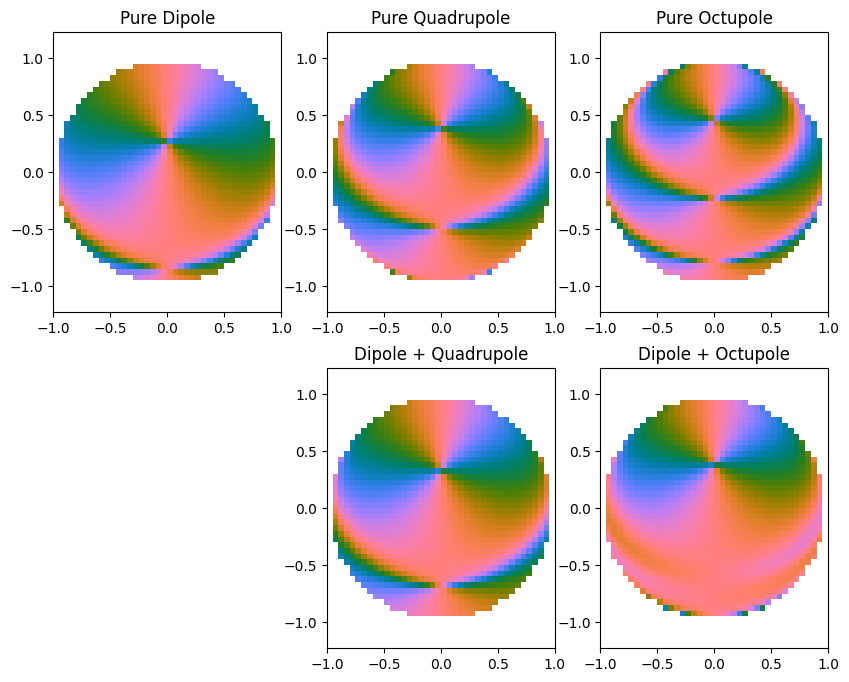

In [19]:
def create_frame(fig, orient = rotation(theta=jnp.pi/4, phi=0.0), adiabatic_radius = 1.0):
    ax1 = fig.add_subplot(231)
    view_projection(ax1, field_components=dipole_component,
                    orient = orient,
                    adiabatic_radius = adiabatic_radius,
                    title="Pure Dipole")
    ax2 = fig.add_subplot(232)
    view_projection(ax2, field_components=quadrupole_component,
                    orient = orient,
                    adiabatic_radius = adiabatic_radius,
                    title="Pure Quadrupole")
    ax3 = fig.add_subplot(233)
    view_projection(ax3, field_components=octupole_component, 
                    orient = orient,
                    adiabatic_radius = adiabatic_radius,
                    title="Pure Octupole")
    ax5 = fig.add_subplot(235)
    view_projection(ax5, field_components=dipole_component+quadrupole_component, 
                    orient = orient,
                    adiabatic_radius = adiabatic_radius,
                    title="Dipole + Quadrupole")
    ax6 = fig.add_subplot(236)
    view_projection(ax6, field_components=dipole_component+octupole_component, 
                    orient = orient,
                    adiabatic_radius = adiabatic_radius,
                    title="Dipole + Octupole")

fig = plt.figure(figsize=(10, 8))
create_frame(fig, adiabatic_radius=1.0)
plt.show()

The differences of the multi-polar magnetic fields are more pronounced closer to the equator and in the southern hemisphere when compared with the pure dipole magnetic field.

The adiabatic radius, where the measurement of the polarization state of the light ray is taken, is an important factor in the how much the multi-polar components affect the polarization state. For an adiabatic radius farther from the surface, the higher-order components fall-off in strength compared with the dipole, which thus dominates the determination of the direction. Hence, the magnetic field topologies of interest are those in which the higher-order components at least dominate close to the surface (by a factor of several).

The best probes for complex magnetic field topology are lower energy photons, which will have a smaller adiabatic radius in comparison to higher energy photons.

In [20]:
from matplotlib.animation import FuncAnimation
import numpy as np
# Number of frames for the full 360-degree rotation
n_frames = 36  # 10-degree steps
phi_values = np.linspace(0, 2*jnp.pi, n_frames)

def create_animation(quad_scale = 1.0, octu_scale = 1.0,
                     theta = jnp.pi/2.1, 
                     adiabatic_radius = 1.0):
    fig = plt.figure(figsize=(10, 8))
    
    # Initialize the subplots
    ax1 = fig.add_subplot(231)
    ax2 = fig.add_subplot(232)
    ax3 = fig.add_subplot(233)
    ax5 = fig.add_subplot(235)
    ax6 = fig.add_subplot(236)
    
    # Function to update the plot for each frame
    def update(frame):
        phi = phi_values[frame]
        orient = rotation(theta=theta, phi=phi)
        
        # Clear axes
        for ax in [ax1, ax2, ax3, ax5, ax6]:
            ax.clear()
        
        view_projection(ax1, field_components=jnp.array([1.0, 0.0, 0.0]),
                      orient=orient, adiabatic_radius=adiabatic_radius,
                      title="Pure Dipole")
        view_projection(ax2, field_components=jnp.array([0.0, 1.0, 0.0]),
                      orient=orient, adiabatic_radius=adiabatic_radius,
                      title="Pure Quadrupole")
        view_projection(ax3, field_components=jnp.array([0.0, 0.0, 1.0]),
                      orient=orient, adiabatic_radius=adiabatic_radius,
                      title="Pure Octupole")
        view_projection(ax5, 
                        field_components=jnp.array([1.0, quad_scale * 1.0, 0.0]),
                        orient=orient, adiabatic_radius=adiabatic_radius,
                        title="Dipole + Quadrupole")
        view_projection(ax6,
                        field_components=jnp.array([1.0, 0.0, octu_scale * 1.0]),
                        orient=orient, adiabatic_radius=adiabatic_radius,
                        title="Dipole + Octupole")
        
        plt.suptitle(f"Phi = {phi:.2f} radians", fontsize=14)
        plt.tight_layout()
    
    # Create the animation
    anim = FuncAnimation(fig, update, frames=n_frames, interval=100)
    plt.close(fig)
    plt.ion()
    
    return anim

# Save the animation using:
# anim.save('field_rotation_matplotlib.gif', writer='pillow', dpi=100)

def display_animation(anim):
    from matplotlib import rc
    from IPython.display import HTML

    # Temporarily enable JavaScript for the HTML video display
    rc('animation', html='jshtml')

    # Convert animation to HTML and display it
    return HTML(anim.to_jshtml())


In [21]:
anim = create_animation(theta=jnp.pi/4.0,
                        adiabatic_radius=5.0,
                        octu_scale=8.0)

display_animation(anim)

<Figure size 640x480 with 0 Axes>

Here, the phase-resolved $\mathcal{Q},\ \mathcal{U}$ are shown to be greatly different from the pure dipole magnetic field view.